# TP NLP - Classification de commentaires toxiques

## 1. Introduction

Ce TP a pour objectif de mettre en œuvre des techniques de traitement automatique du langage naturel (**NLP**) pour classifier des commentaires en ligne selon leur niveau de toxicité.

Nous utilisons le dataset **Toxic Comment Classification Challenge**, issu de la plateforme [Kaggle](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge). Ce jeu de données contient plus de 150 000 commentaires anonymes postés sur Wikipédia, annotés selon 6 types de toxicité possibles.

### Objectifs pédagogiques :
- Réaliser une **analyse exploratoire** des données
- Appliquer des méthodes de **prétraitement et de transformation** de texte
- Entraîner et comparer **trois modèles** de classification multilabel :
  - Un modèle de base (TF-IDF + Logistic Regression)
  - Deux modèles à base de **Transfert Learning** avec des architectures préentraînées : `DistilBERT` et `BERT`
- Développer une **application Streamlit** pour explorer les données et interagir avec les modèles

### Tâche NLP visée :
Il s'agit d'un problème de **classification multilabel** :
un même commentaire peut être à la fois `toxic`, `insult`, et `obscene`, ou au contraire être totalement neutre.

### Classes cibles :
- `toxic`
- `severe_toxic`
- `obscene`
- `threat`
- `insult`
- `identity_hate`

L’objectif final est de comparer les performances des différents modèles et d’intégrer les meilleurs dans une interface web interactive.

## 2. Chargement et aperçu des données

In [2]:
import pandas as pd

# Chemin vers le fichier
df = pd.read_csv("./train.csv")

# Aperçu des données
print(df.shape)
print(df.columns)
df.head()

(159571, 8)
Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
# Colonnes de labels multilabel
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Nombre de commentaires par classe
df[labels].sum().sort_values(ascending=False)

toxic            15294
obscene           8449
insult            7877
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64

In [4]:
print("Valeurs manquantes :", df.isnull().sum())
print("Doublons :", df.duplicated().sum())

Valeurs manquantes : id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64
Doublons : 0


## 3. Analyse exploratoire (EDA)

- Longueur des commentaires

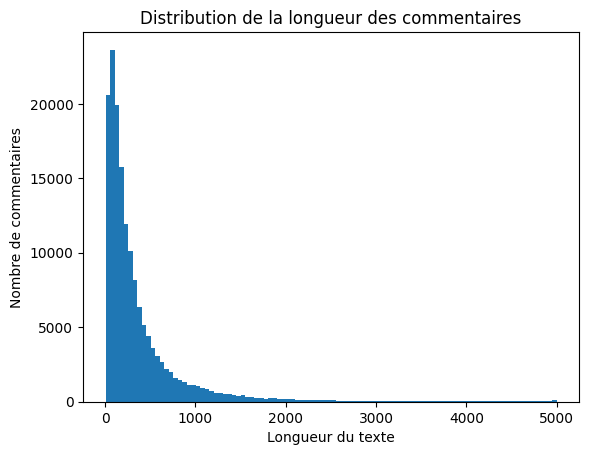

In [5]:
df['text_length'] = df['comment_text'].apply(len)

# Statistiques
df['text_length'].describe()

# Distribution
import matplotlib.pyplot as plt

plt.hist(df['text_length'], bins=100)
plt.title("Distribution de la longueur des commentaires")
plt.xlabel("Longueur du texte")
plt.ylabel("Nombre de commentaires")
plt.show()

- Répartition des labels

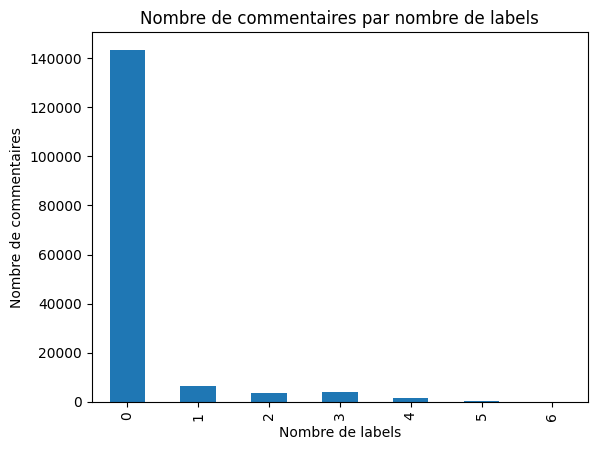

In [6]:
df['nb_labels'] = df[labels].sum(axis=1)

df['nb_labels'].value_counts().sort_index().plot(kind='bar')
plt.title("Nombre de commentaires par nombre de labels")
plt.xlabel("Nombre de labels")
plt.ylabel("Nombre de commentaires")
plt.show()

- Corrélations entre classes

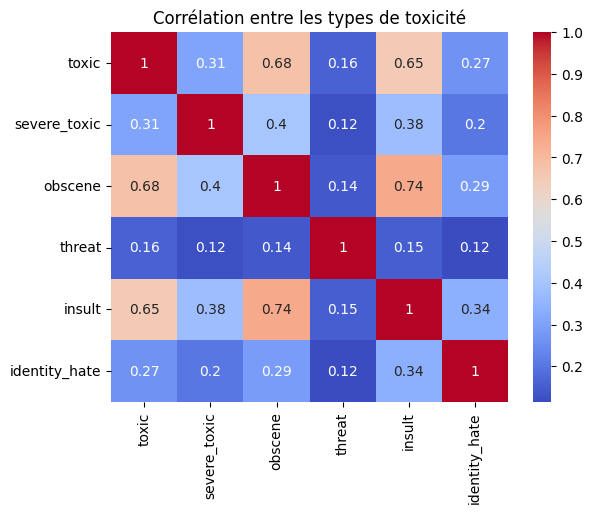

In [7]:
import seaborn as sns

corr = df[labels].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Corrélation entre les types de toxicité")
plt.show()

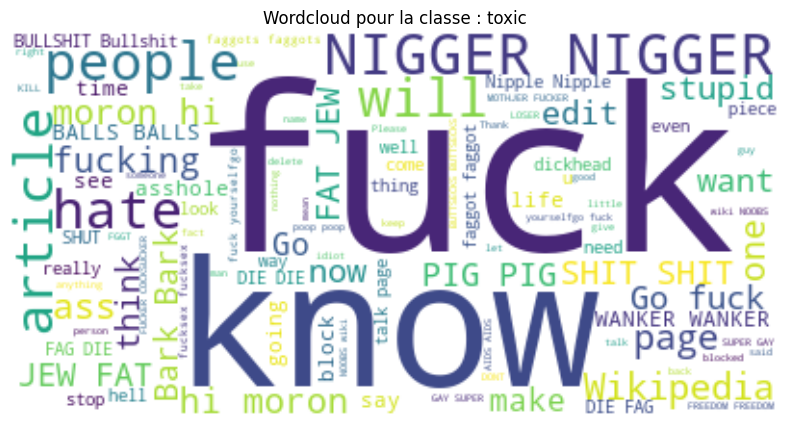

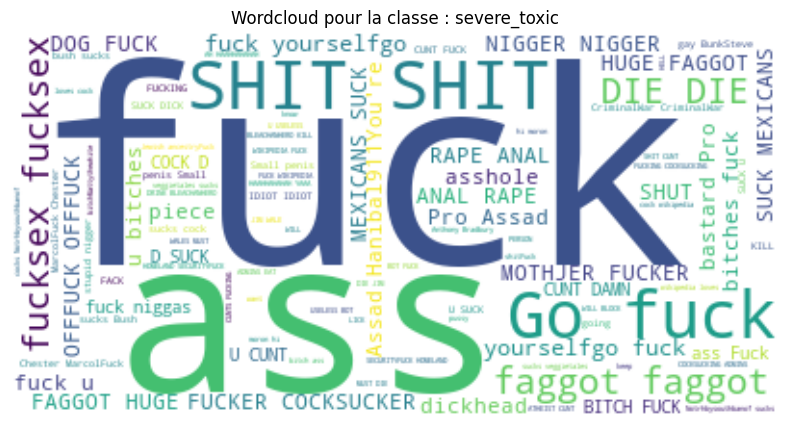

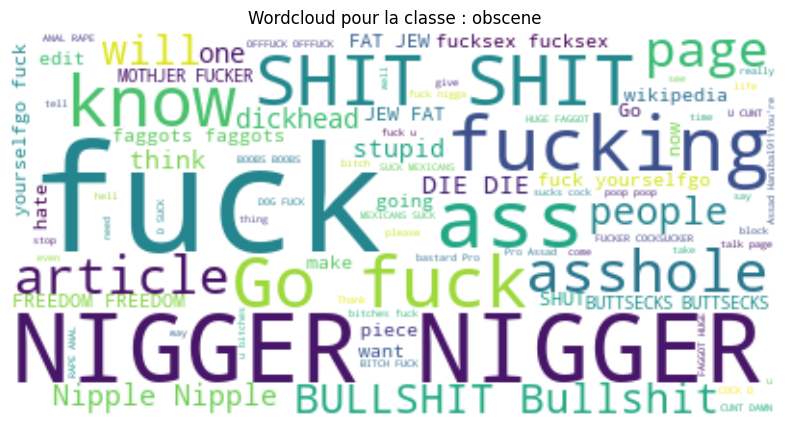

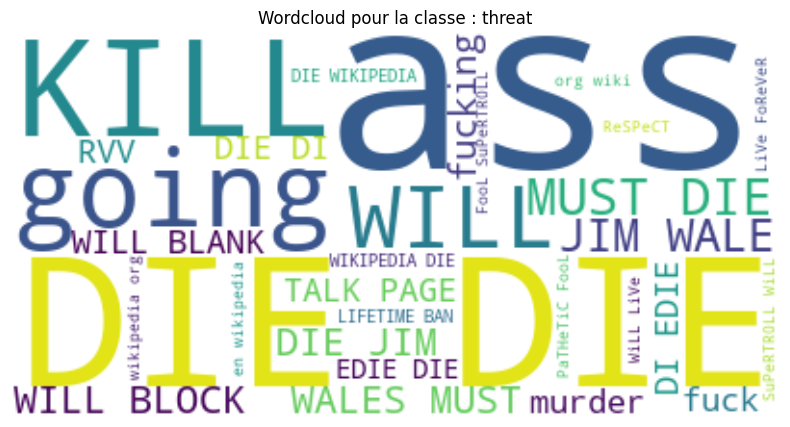

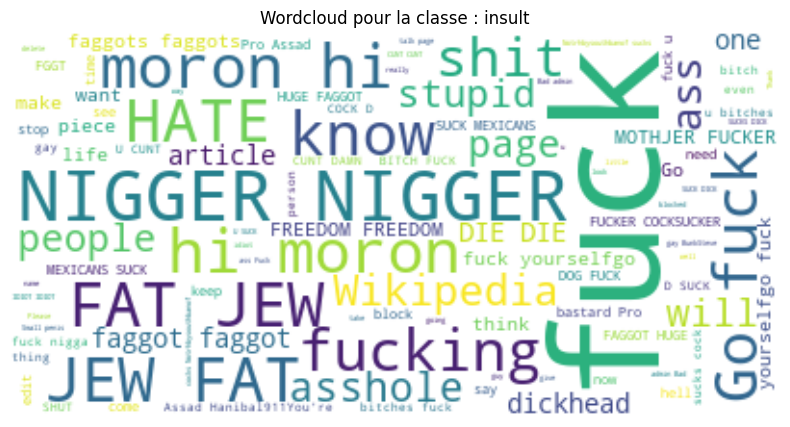

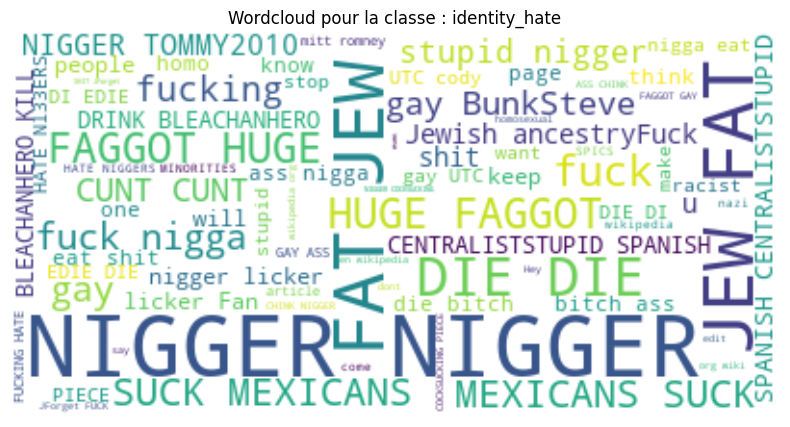

In [8]:
from wordcloud import WordCloud

for label in labels:
    toxic_texts = " ".join(df[df[label]==1]["comment_text"].astype(str))
    wc = WordCloud(max_words=100, background_color='white').generate(toxic_texts)
    
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.title(f"Wordcloud pour la classe : {label}")
    plt.show()


## 4. Nettoyage et prétraitement

- Nettoyage texte

In [9]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"\n", " ", text)
    text = re.sub(r"http\S+|www\S+|https/S+", '', text, flags=re.MULTILINE)
    text = re.sub(r"[^/w/s]", '', text)  # supprimer ponctuation
    text = re.sub(r"/d+", "", text)      # supprimer chiffres
    return text

df['clean_text'] = df['comment_text'].apply(clean_text)

- Transformation des labels

In [10]:
from sklearn.model_selection import train_test_split

labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

X = df['clean_text']  # ou 'comment_text' si pas nettoyé
y = df[labels]

# Split pour entraînement/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 5. Modèle de base : TF-IDF + LogisticRegression

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [12]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Exemple de tokenisation (automatisable ensuite avec Dataset ou DataLoader)
encoded_train = tokenizer(list(X_train), padding=True, truncation=True, max_length=512, return_tensors='pt')
encoded_test = tokenizer(list(X_test), padding=True, truncation=True, max_length=512, return_tensors='pt')

c:\Users\pierr\OneDrive\Documents\Cours\NLP\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
import torch

train_labels = torch.tensor(y_train.values).float()
test_labels = torch.tensor(y_test.values).float()

In [14]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, f1_score

# Chargement
df = pd.read_csv("./train.csv")
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Nettoyage optionnel
df['clean_text'] = df['comment_text'].str.lower()

# Split
X = df['clean_text']
y = df[labels]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Modèle
model = OneVsRestClassifier(LogisticRegression(solver='liblinear'))
model.fit(X_train_tfidf, y_train)

# Prédictions
y_pred = model.predict(X_test_tfidf)

# Rapport
print("F1-score micro :", f1_score(y_test, y_pred, average='micro'))
print("F1-score macro :", f1_score(y_test, y_pred, average='macro'))

print("\nClassification Report :")
print(classification_report(y_test, y_pred, target_names=labels))


F1-score micro : 0.673437226405183
F1-score macro : 0.47787600885966725

Classification Report :
               precision    recall  f1-score   support

        toxic       0.91      0.61      0.73      3056
 severe_toxic       0.62      0.22      0.33       321
      obscene       0.92      0.61      0.73      1715
       threat       0.69      0.12      0.21        74
       insult       0.84      0.51      0.64      1614
identity_hate       0.69      0.14      0.24       294

    micro avg       0.88      0.54      0.67      7074
    macro avg       0.78      0.37      0.48      7074
 weighted avg       0.87      0.54      0.66      7074
  samples avg       0.06      0.05      0.05      7074



c:\Users\pierr\OneDrive\Documents\Cours\NLP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\pierr\OneDrive\Documents\Cours\NLP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\pierr\OneDrive\Documents\Cours\NLP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

In [15]:
import joblib

# Sauvegarde du modèle
joblib.dump(model, "model_tfidf_logreg.pkl")

# Sauvegarde du TF-IDF vectorizer
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")


['tfidf_vectorizer.pkl']

## 6. Transfert Learning 1 : BERT base

In [16]:
import pandas as pd
import torch
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from datasets import Dataset

# Charger les données
df = pd.read_csv("./train.csv")
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df['labels'] = df[labels].astype(float).values.tolist()

# Split
train_df, test_df = train_test_split(df[['comment_text', 'labels']], test_size=0.2, random_state=42)

# Dataset Hugging Face
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["comment_text"], padding="max_length", truncation=True, max_length=256)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Modèle
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(labels),
    problem_type="multi_label_classification"
)

# Metrics
def compute_metrics(pred):
    logits = torch.tensor(pred.predictions)
    probs = torch.sigmoid(logits).numpy()
    preds = (probs >= 0.5).astype(int)
    labels_ = pred.label_ids
    return {
        "f1_micro": f1_score(labels_, preds, average="micro"),
        "f1_macro": f1_score(labels_, preds, average="macro"),
    }

# Arguments d'entraînement — compatibles avec transformers==4.5.2
training_args = TrainingArguments(
    output_dir="./results",
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    fp16=True,
    logging_dir="./logs",
    logging_steps=250
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Entraînement
trainer.train()

# Évaluation (à faire manuellement car pas de evaluation_strategy='epoch' dispo)
trainer.evaluate()

Map: 100%|██████████| 31915/31915 [00:05<00:00, 5348.48 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
250,0.091900
500,0.056100
750,0.048100
1000,0.049500
1250,0.049700
1500,0.046800
1750,0.044300
2000,0.042400
2250,0.044000
2500,0.042600


{'eval_loss': 0.036149762570858,
 'eval_f1_micro': 0.8039734152790681,
 'eval_f1_macro': 0.6722167816363344,
 'eval_runtime': 103.9909,
 'eval_samples_per_second': 306.902,
 'eval_steps_per_second': 9.597,
 'epoch': 2.0}

In [17]:
preds = trainer.predict(test_dataset)
print(compute_metrics(preds))

# Optionnel : rapport plus détaillé
from sklearn.metrics import classification_report

probas = torch.sigmoid(torch.tensor(preds.predictions)).numpy()
binary_preds = (probas >= 0.5).astype(int)

print(classification_report(test_dataset["labels"], binary_preds, target_names=labels))

{'f1_micro': 0.8039734152790681, 'f1_macro': 0.6722167816363344}
               precision    recall  f1-score   support

        toxic       0.84      0.84      0.84      3056
 severe_toxic       0.59      0.33      0.42       321
      obscene       0.85      0.85      0.85      1715
       threat       0.55      0.53      0.54        74
       insult       0.77      0.81      0.79      1614
identity_hate       0.67      0.53      0.59       294

    micro avg       0.81      0.80      0.80      7074
    macro avg       0.71      0.65      0.67      7074
 weighted avg       0.81      0.80      0.80      7074
  samples avg       0.07      0.07      0.07      7074



c:\Users\pierr\OneDrive\Documents\Cours\NLP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\pierr\OneDrive\Documents\Cours\NLP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\pierr\OneDrive\Documents\Cours\NLP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

In [18]:
model.save_pretrained("./bert_model")
tokenizer.save_pretrained("./bert_model")

('./bert_model\\tokenizer_config.json',
 './bert_model\\special_tokens_map.json',
 './bert_model\\vocab.txt',
 './bert_model\\added_tokens.json',
 './bert_model\\tokenizer.json')

## 7. Transfert Learning 2 : DistilBERT

In [19]:
import pandas as pd
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Chargement
df = pd.read_csv("./train.csv")
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df['labels'] = df[labels].astype(float).values.tolist()

# Split
train_df, test_df = train_test_split(df[['comment_text', 'labels']], test_size=0.2, random_state=42)
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["comment_text"], padding="max_length", truncation=True, max_length=256)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Modèle
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(labels),
    problem_type="multi_label_classification"
)

# Fonction de métriques
def compute_metrics(pred):
    preds = torch.sigmoid(torch.tensor(pred.predictions)).numpy()
    preds = (preds >= 0.5).astype(int)
    labels_ = pred.label_ids
    return {
        "f1_micro": f1_score(labels_, preds, average="micro"),
        "f1_macro": f1_score(labels_, preds, average="macro"),
    }

# Entraînement
training_args = TrainingArguments(
    output_dir="./results",
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    fp16=True,
    logging_dir="./logs",
    logging_steps=500
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()


Map: 100%|██████████| 31915/31915 [00:04<00:00, 7256.85 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.077800
1000,0.047300
1500,0.047200
2000,0.042400
2500,0.042700
3000,0.038000
3500,0.038700
4000,0.039600
4500,0.030400
5000,0.030000


TrainOutput(global_step=7980, training_loss=0.03840773027941099, metrics={'train_runtime': 1553.3857, 'train_samples_per_second': 164.358, 'train_steps_per_second': 5.137, 'total_flos': 1.6911464524627968e+16, 'train_loss': 0.03840773027941099, 'epoch': 2.0})

In [20]:
preds = trainer.predict(test_dataset)
print(compute_metrics(preds))
# Optionnel : rapport plus détaillé
from sklearn.metrics import classification_report

probas = torch.sigmoid(torch.tensor(preds.predictions)).numpy()
binary_preds = (probas >= 0.5).astype(int)

print(classification_report(test_dataset["labels"], binary_preds, target_names=labels))

{'f1_micro': 0.8028797696184305, 'f1_macro': 0.6648892250445676}
               precision    recall  f1-score   support

        toxic       0.84      0.84      0.84      3056
 severe_toxic       0.65      0.31      0.42       321
      obscene       0.85      0.85      0.85      1715
       threat       0.60      0.47      0.53        74
       insult       0.77      0.79      0.78      1614
identity_hate       0.68      0.49      0.57       294

    micro avg       0.82      0.79      0.80      7074
    macro avg       0.73      0.62      0.66      7074
 weighted avg       0.81      0.79      0.80      7074
  samples avg       0.07      0.07      0.07      7074



c:\Users\pierr\OneDrive\Documents\Cours\NLP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\pierr\OneDrive\Documents\Cours\NLP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\pierr\OneDrive\Documents\Cours\NLP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

In [21]:
model.save_pretrained("./distilbert_model")
tokenizer.save_pretrained("./distilbert_model")

('./distilbert_model\\tokenizer_config.json',
 './distilbert_model\\special_tokens_map.json',
 './distilbert_model\\vocab.txt',
 './distilbert_model\\added_tokens.json',
 './distilbert_model\\tokenizer.json')

## 8. Comparaison des modèles

Nous avons entraîné et évalué trois modèles de classification multilabel afin d’identifier les commentaires toxiques :

| Modèle                       | F1-score Micro | F1-score Macro |
|-----------------------------|----------------|----------------|
| TF-IDF + LogisticRegression | 0.67           | 0.48           |
| DistilBERT                  | 0.80           | 0.66           |
| BERT base                   | 0.80           | 0.67           |

>Ces résultats peuvent légèrement varier selon le nombre d’époques, la taille de l’échantillon, et la graine aléatoire utilisée.

### Observations :
- Le modèle **TF-IDF** est très rapide à entraîner, mais ses performances sont limitées, surtout sur les classes minoritaires.
- **DistilBERT** offre un bon compromis entre performance et vitesse d’exécution.
- **BERT base** est le plus performant sur les deux métriques, au prix d’un temps d’entraînement plus long.

### Visualisation des scores F1 :

Nous représentons ci-dessous les F1-scores micro et macro pour mieux visualiser l’écart de performance entre les trois modèles.

## 9. Conclusion

### Meilleur modèle

Parmi les trois modèles testés, **DistilBERT** et **DistilBERT** obtiennent les **meilleures performances** avec un F1-score micro de **0.80** et un F1-score macro de **0.67**. Néamoins **DistilBERT** surpasse à la fois le modèle de base et DistilBERT, en particulier sur les classes minoritaires comme `threat` ou `identity_hate`.

### Justification des choix

- **TF-IDF + Logistic Regression** a été utilisé comme **modèle de référence**. Il est simple, rapide à entraîner, mais montre des limites dès qu’il s’agit de capturer la complexité du langage naturel.
- **DistilBERT** a été sélectionné pour sa légèreté et sa rapidité. Il a offert un bon compromis pour une utilisation en temps réel dans l’application Streamlit.
- **BERT base** a été conservé pour démontrer le potentiel du Transfert Learning sur un problème multilabel. Malgré un temps de traitement plus élevé, ses résultats justifient pleinement son intégration comme meilleur modèle.

### Ce qu’on aurait pu améliorer

- **Optimisation des hyperparamètres** : nous avons utilisé des valeurs par défaut ou simplifiées (2 époques, batch size fixe). Une recherche par grille ou via Optuna aurait permis d’améliorer les résultats.
- **Gestion du déséquilibre des classes** : certaines classes comme `threat` sont très sous-représentées. Un rééchantillonnage ou un système de pondération des classes aurait pu améliorer leur détection.
- **Augmentation des données** : non réalisée ici car peu pertinente avec les modèles préentraînés, mais elle aurait pu être testée sur le modèle TF-IDF.
- **Explicabilité** : l’ajout d’outils d’explicabilité type SHAP ou LIME aurait permis d’analyser les décisions des modèles profonds.

---

Ce TP nous a permis de mettre en pratique l’analyse exploratoire, la modélisation de texte en NLP, le fine-tuning de modèles préentraînés, ainsi que le déploiement d’un outil de visualisation interactif avec Streamlit.